# Inception-Net-V3 Notebook

In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

## Contents

### Directories

In [51]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
DATA_PATH = DATA_BASE_PATH / "splited-data"

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Variables

In [52]:
RANDOM_SEED = 42
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 64

CLASS_NAMES = sorted([img_cls for img_cls in  os.listdir(TRAIN_PATH) if img_cls != ".DS_Store"])
NUM_CLASSES = len(CLASS_NAMES)

# MODEL
MODEL_PATH = ROOT_DIR / "models"
LOG_PATH = ROOT_DIR / "log"



In [53]:
tf.random.set_seed(RANDOM_SEED)

### Data Augmentation

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    
    horizontal_flip=True,
    
    rotation_range=20,
    
    height_shift_range=0.1,       # No need to shift the image
    width_shift_range=0.1,
    zoom_range=0.1,
    
    shear_range=0.1,              # Seems to be useful
    
    validation_split=VALIDATION_SPLIT,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    )

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [55]:
train_images = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='training',
)

val_images = val_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='validation'
)


test_images = test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
)

NUM_TRAIN_IMAGES = len(train_images.filenames)
NUM_VAL_IMAGES = len(val_images.filenames)
NUM_TEST_IMAGES = len(test_images.filenames)

Found 12369 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 5186 images belonging to 120 classes.


### LOADING DATA

In [56]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    if len(y.shape) == 2:
        y = y.argmax(axis=1)
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"\n({labels[i]})"
        plt.title(title)
        plt.axis("off")
        # increase vertical space between subplots
        plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    

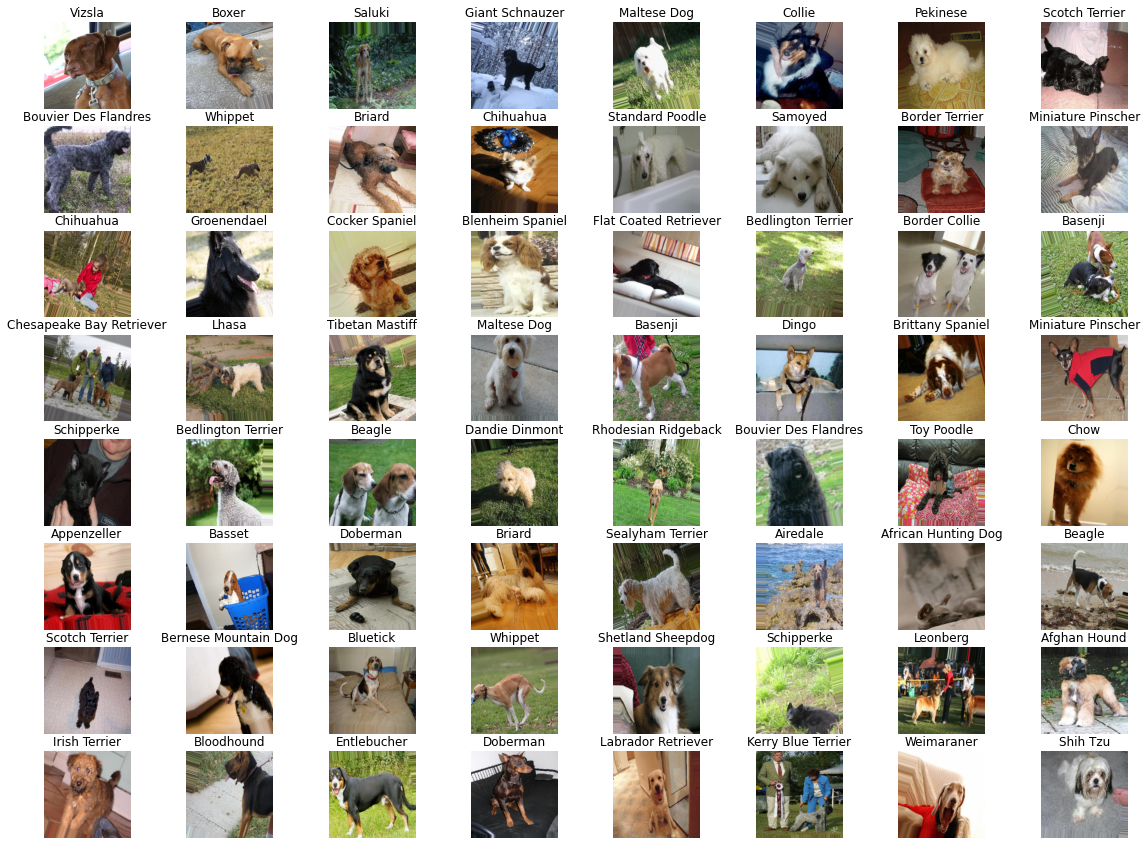

In [57]:
num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 15))

images, labels = train_images.next()
for i in range(num_cols * num_rows):
    plt.subplot(num_cols, num_rows, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

## Model

In [58]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


### Valribles

In [59]:
INPUT_SHAPE = train_images.next()[0][0].shape
TRAIN_MODELS = True
TRAIN_MODELS = False

### Useful functions ###

In [60]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def get_model_performance(y_true, y_pred):
    if len(y_true.shape) == 2:
        y_true = y_true.argmax(axis=1)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    f1_scr = f1_score(y_true, y_pred, average='weighted')
    precision_scr = precision_score(y_true, y_pred, average='weighted')
    recall_scr = recall_score(y_true, y_pred, average='weighted')
    
    performance = {
        "Accuracy": accuracy,
        "F1 Score": f1_scr,
        "Precision": precision_scr,
        "Recall": recall_scr
    }
    
    return performance
    

### MODELS

#### MODEL ARCHITECTURE

In [61]:
from tensorflow.keras.models import Sequential

model_name = "TL-Inception-net-V3"
weight_decay = 10e-5
LEARNING_RATE = 1e-3
# weight_decay = 0

def final_model(base_model, num_classes: int):
    model = Sequential(name=model_name)
    
    base_model.trainable = False
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.3))
    
    model.add(Dense(512, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dropout(0.4))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [62]:
# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# InceptionV3.summary()
print("Total Params:", InceptionV3.count_params())

Total Params: 21802784


In [63]:
model = final_model(InceptionV3, num_classes=NUM_CLASSES)

model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "TL-Inception-net-V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_189 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 activation_189 (Activation)  (None, 512)      

#### Model Training

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger

monitor_metric = 'val_accuracy'

# Early stopping
es = EarlyStopping(
        monitor=monitor_metric,
        patience=5,
        mode = "auto",
        verbose=1,
)

# Learning rate scheduler
def step_decay(epoch):
    initial_lr = LEARNING_RATE
    k = 0.1
    lr = initial_lr * np.exp(-k*epoch)
    return lr

lrd = LearningRateScheduler(step_decay)

# Model Checkpoint
mdl_check = ModelCheckpoint(
        MODEL_PATH / f"{model.name}.h5",
        monitor=monitor_metric,
        save_best_only=True,
        mode='auto',
        verbose=1,
)
        
# CSV Logger
csv_logger = CSVLogger(
        LOG_PATH / f"{model.name}.csv",
        append=False,
)


callbacks = [
        es, 
        lrd,
        mdl_check, 
        # csv_logger,
    ]

In [83]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model_name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=50, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model_name}.h5"
    model = load_model(model_path)
    print(f"{model_name} model loaded from {model_path}")
    

Epoch 1/50


2022-07-10 23:44:19.638691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 18/194 [=>............................] - ETA: 1:16 - loss: 0.7930 - accuracy: 0.7995 - top_k_categorical_accuracy: 0.9705

KeyboardInterrupt: 

In [66]:
if train_model:
    plot_model_performance(history)

In [67]:
if train_model:
    model.evaluate(test_images)

2022-07-10 23:40:42.752417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


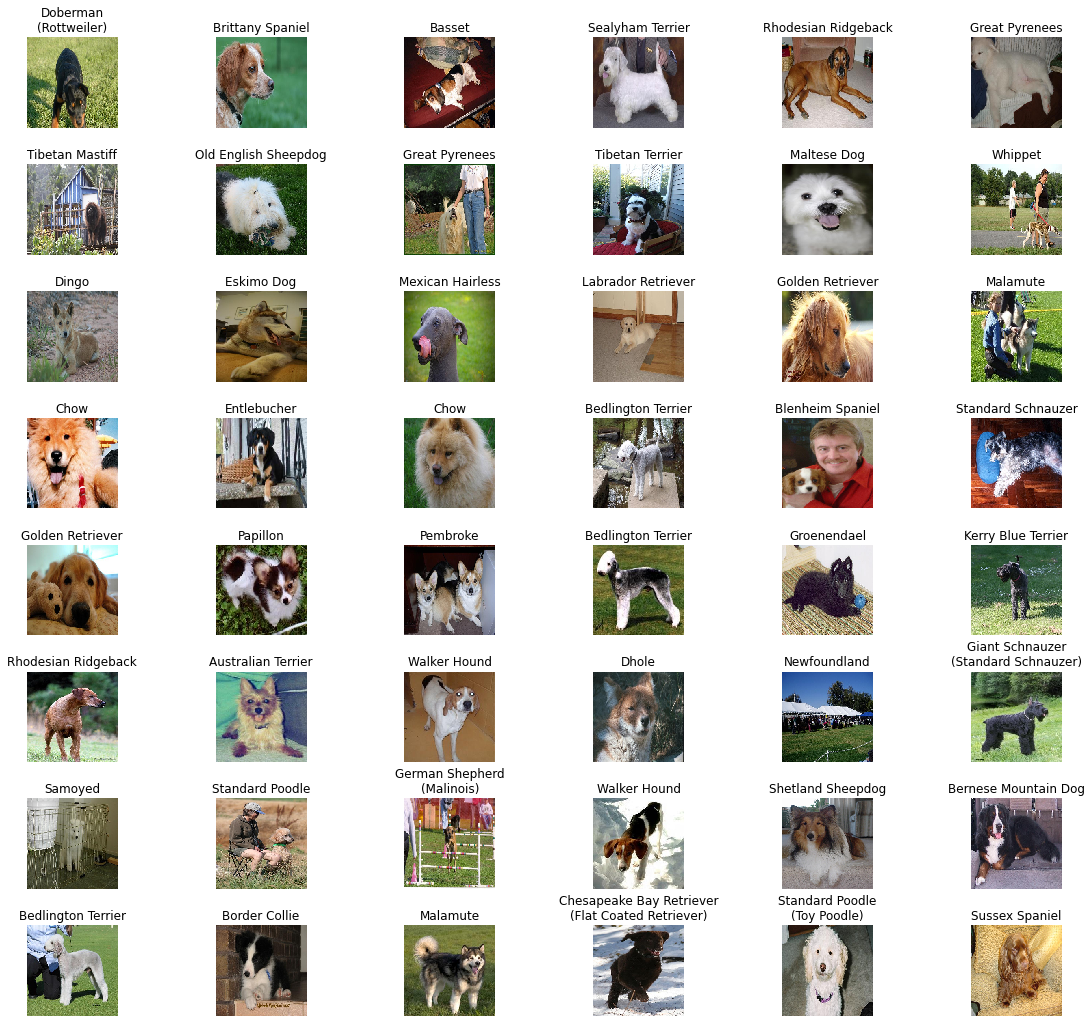

In [68]:
plt_size = (20, 18)

num_rows = 8
num_cols = 6

test_images.batch_size = num_rows * num_cols

images, labels = test_images.next()
labels_pred = predict_label(images, model)

display_image_grid(
                images, 
                give_class_name(labels), give_class_name(labels_pred),
                shape=(num_rows, num_cols),
                figsize=plt_size,
                )

In [78]:
test_images.reset()
test_images.batch_size = 16
test_images.shuffle = False

test_labels = test_images.labels
test_labels_pred_ohe = model.predict_generator(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)

/var/folders/10/d1l6p8_s53q1w912xq9jh2_80000gn/T/ipykernel_54842/1177065413.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_labels_pred_ohe = model.predict_generator(test_images)


## Classification Report

In [82]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)
print("Score:", performance["Accuracy"])
print(classification_report(test_labels, test_labels_pred))


Score: 0.8802545314307751
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        38
           1       0.97      0.98      0.98        60
           2       0.98      1.00      0.99        43
           3       0.92      0.88      0.90        51
           4       0.79      0.80      0.80        41
           5       0.82      0.71      0.76        38
           6       0.85      0.80      0.82        49
           7       0.84      1.00      0.91        53
           8       0.87      0.93      0.90        44
           9       0.81      0.90      0.85        49
          10       0.96      1.00      0.98        46
          11       0.86      0.98      0.92        55
          12       0.82      0.82      0.82        40
          13       0.98      0.96      0.97        47
          14       0.79      0.87      0.83        47
          15       0.93      0.91      0.92        43
          16       0.71      0.79      0.75        38
 

In [99]:
# top 5 accuracy and classification report
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import top_k_categorical_accuracy

test_labels_ohe = tf.keras.utils.to_categorical (test_labels)
top_5_accuracy = top_k_categorical_accuracy(test_labels_ohe, test_labels_pred_ohe, k=5)

top_5_accuracy = top_5_accuracy.numpy().sum() / len(test_labels)

print(f"Top 5 accuracy: {top_5_accuracy:.2%}")

Top 5 accuracy: 98.63%
